In [3]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math 
import mmh3 
sns.set()

In [4]:
DATA_PATH_ORIG = r'../data/capture20110812.pcap.netflow.labeled.csv'
DATA_PATH_NEW = r'../data/capture20110812.pcap.netflow.labeled_processed.csv'

## IMPORTANT     
The code below reads the file and erases the '->' characters.    
It takes quite a few minutes, so run it only if you don't have the processed file yet :(

In [5]:
#text = open(DATA_PATH_ORIG, "r")
#text = ''.join([i for i in text]) \
#     .replace("->", "")
#x = open(DATA_PATH_NEW,"w")
#x.writelines(text)
#x.close()

In [6]:
column_names = ['_', '_2', 'duration', 'protocol', 'src_addr', 'dst_addr', 'flags', 'tos', 'packets', 'bytes', 'flows', 'label']

df = pd.read_csv(
    DATA_PATH_NEW,
    delimiter='\s+',
    skiprows=[0],
    header=None, 
    names=column_names,
    index_col=False,
    parse_dates={"start_date": [0,1]}
)
df.head()

,start_date,duration,protocol,src_addr,dst_addr,flags,tos,packets,bytes,flows,label
0,2011-08-12 15:24:01.105,4.677,TCP,74.125.108.243:80,147.32.86.187:55707,PA_,0,452,682688,1,Background
1,2011-08-12 15:24:01.105,3.110,TCP,147.32.84.164:22,83.208.193.123:15173,PA_,0,5,506,1,LEGITIMATE
2,2011-08-12 15:24:01.105,4.678,TCP,147.32.86.187:55707,74.125.108.243:80,A_,0,106,6510,1,LEGITIMATE
3,2011-08-12 15:24:01.106,4.989,TCP,217.168.211.184:3953,147.32.84.14:22,PA_,0,1393,95812,1,Background
4,2011-08-12 15:24:01.113,4.988,UDP,173.9.132.155:54369,147.32.84.59:15046,INT,0,811,680898,1,Background


We obtained the IP of the infected host from the documentation of the scenario 44.

In [7]:
host_ip = "147.32.84.165" # IP obtained from documentation

Let's keep all the other IPs the host connects with

In [8]:
# let's build an iterable with all the other IPs this guy connects with
connections = df[(df['src_addr'] == host_ip) | (df['dst_addr'] == host_ip)][['src_addr', 'dst_addr']]

other_ips = connections.apply(lambda row: row['dst_addr'] if row['src_addr'] == host_ip else row['src_addr'], axis=1)
print(f"{other_ips.size} connections with the host found.")

3652 connections with the host found.


Just a sanity check to assert that we do not have our host_ip somewhere in the list of IPs

In [9]:
print(len([ip for ip in other_ips if ip != host_ip]))
print(len(other_ips))

3652
3652


# Count Min Sketch

Resource: https://olivif.github.io/2017/count-min-sketch/

Resource for independent hash functions: https://www.geeksforgeeks.org/bloom-filters-introduction-and-python-implementation/

Let's starts by implementing the function that computes the INDEPEDENT hashings.

In [10]:
def get_hash_indexes(item, hash_count, bit_array_size):
    digests = [] 
    for i in range(hash_count):  
        digest = mmh3.hash(item,i) % bit_array_size 
        digests.append(digest) 
  
    return digests
    

In [27]:
def get_count_min_sketch_buckets(original, height, width):
    buckets = np.zeros((height, width))
    unique_ips = set()

    for ip in original:
        digests = get_hash_indexes(ip, height, width)
        unique_ips.add(ip)

        for id_height, id_width in enumerate(digests):
            buckets[id_height, id_width] += 1
            
    return unique_ips, buckets


In [36]:
#Loop over the unique ips, hash them again, get the counts from the indexes and choose the min one as frequency
def get_frequencies(unique_ips, buckets, height, width):
    frequencies = []
    for ip in unique_ips:
        hash_ip = get_hash_indexes(ip, height, width)

        bucket_values = []

        for id_height, id_width in enumerate(hash_ip):
            bucket_values.append( buckets[id_height, id_width])

        frequencies.append(np.min(bucket_values)/len(other_ips))

    freq_series = pd.Series(frequencies, index = unique_ips)
    freq_series = freq_series.sort_values(ascending=False)

    return freq_series

In [39]:
def compute_count_min_sketch_error(original, sampled_freq, n_of_ips):
    original = original.value_counts().sort_values(ascending=False)
    
    top_n_to_find = original[:n_of_ips].index
    top_n_found = sampled_freq[:n_of_ips].index
        
    retrieved = set.intersection(set(top_n_to_find), set(top_n_found))
    return len(retrieved)

In [54]:
height = np.arange(2, 10, 1)
width =  np.arange(50, len(other_ips), 25)

results = np.zeros((len(height), len(width)))

for i, h in enumerate(height):
    for j, w in enumerate(width):
        
        #print(f"Height {h} and width {w}")
        unique_ips, buckets = get_count_min_sketch_buckets(other_ips, h, w)
        freq = get_frequencies(unique_ips, buckets, h, w)
        error = compute_count_min_sketch_error(other_ips, freq, 10)
        
        results[i,j] = error

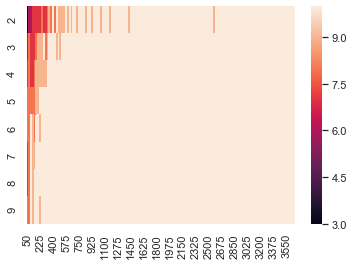

In [55]:
results_df =pd.DataFrame(results, index = height, columns=width)
sns.heatmap(results_df)

Based on the plot above, we see that above half the total number pf ips the error is very high, so let's only look until halfway.

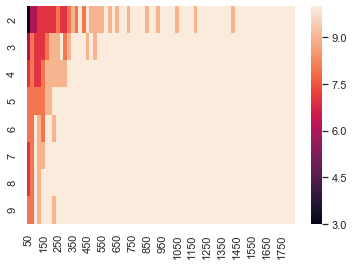

In [56]:
results_df_half = results_df[results_df.columns[:int(len(results_df.columns)/2)]]
results_df_half.head()

sns.heatmap(results_df_half)

In [57]:
len(unique_ips)

1269

For reservoir, we get to 10 successfully retrieved IPs around 2500 reservoir size. However, as we can observe in the case of Count Min Sketching, we can achieve this with lower size. We get steady around height of 5 and width of 300 (so total size 5 * 300 = 1500) as we can observe in the heatmap above. 

However, considering that for Count Min Sketch we also need to store the unique ips for retrieving the minimum bucket size, overall we do need to store more items in memory than in the case of reservoir sampling.

Accuracy wise, both methods are accurate given high enough values for the parameters (i.e. reservoir size and height and width for the 'buckets' matrix for Count Min Sketch). 